# 📧 Vector Clocks in Distributed Email System
This notebook demonstrates **Vector Clocks** through a distributed email delivery system.

You will explore:
1. Vector clock simulation (servers sending/receiving emails).
2. Concurrency detection.
3. Visualization of causal and concurrent events.

By the end, you will understand how vector clocks detect concurrency while Lamport clocks cannot.

In [4]:

class VectorClock:
    def __init__(self, pid, num_processes):
        self.pid = pid
        self.num_processes = num_processes
        self.vector = [0] * num_processes

    def tick(self, task="Local Event"):
        """Local event"""
        self.vector[self.pid] += 1
        print(f"[Server {self.pid}] executes '{task}' → {self.vector}")
        return self.vector.copy()

    def send(self, task="Send Message"):
        """Send event"""
        self.vector[self.pid] += 1
        print(f"📤 [Server {self.pid}] '{task}' sent → {self.vector}")
        return self.vector.copy()

    def receive(self, incoming_vector, task="Receive Message"):
        """Receive event"""
        self.vector = [max(self.vector[i], incoming_vector[i]) for i in range(self.num_processes)]
        self.vector[self.pid] += 1
        print(f"📥 [Server {self.pid}] '{task}' received → {self.vector}")
        return self.vector.copy()


## 🔹 Simulation: Email Delivery System with 3 Servers
- **Server A** drafts and sends emails.
- **Server B** applies spam filters.
- **Server C** stores emails in inbox.
- We simulate message passing and concurrent tasks.

In [5]:

# Initialize servers (A=0, B=1, C=2)
A = VectorClock(0, 3)
B = VectorClock(1, 3)
C = VectorClock(2, 3)

# Step 1: Local events
A.tick("Draft Email 1")
B.tick("Update Spam Rules")
C.tick("Clean Inbox")

# Step 2: A sends Email 1 to C
msg = A.send("Email 1 to C")
C.receive(msg, "Store Email 1")

# Step 3: Concurrent events (independent)
A.tick("Draft Email 2 (Concurrent)")
B.tick("Update Spam Rules Again (Concurrent)")

# Step 4: B flags spam and notifies C
msg = B.send("Spam Alert to C")
C.receive(msg, "Block Spam Email")

print("\n--- Final Vector Clocks ---")
print("Server A:", A.vector)
print("Server B:", B.vector)
print("Server C:", C.vector)


[Server 0] executes 'Draft Email 1' → [1, 0, 0]
[Server 1] executes 'Update Spam Rules' → [0, 1, 0]
[Server 2] executes 'Clean Inbox' → [0, 0, 1]
📤 [Server 0] 'Email 1 to C' sent → [2, 0, 0]
📥 [Server 2] 'Store Email 1' received → [2, 0, 2]
[Server 0] executes 'Draft Email 2 (Concurrent)' → [3, 0, 0]
[Server 1] executes 'Update Spam Rules Again (Concurrent)' → [0, 2, 0]
📤 [Server 1] 'Spam Alert to C' sent → [0, 3, 0]
📥 [Server 2] 'Block Spam Email' received → [2, 3, 3]

--- Final Vector Clocks ---
Server A: [3, 0, 0]
Server B: [0, 3, 0]
Server C: [2, 3, 3]


## 🔹 Visualization of Events
We now plot the causal (message passing) and concurrent events on a timeline.

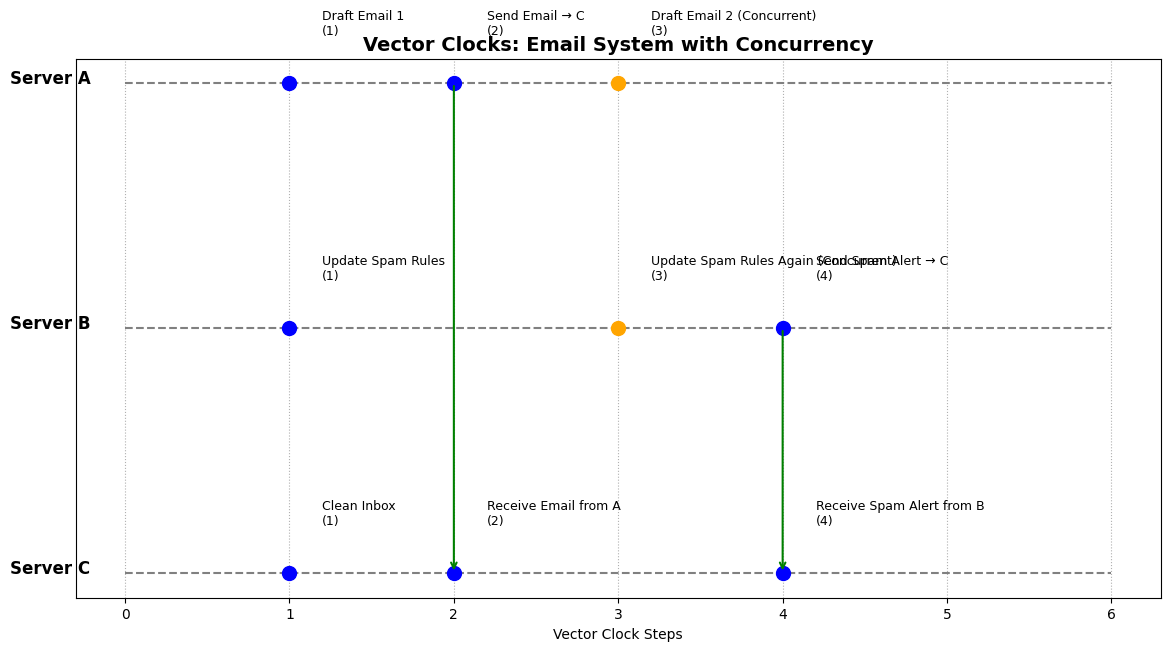

In [6]:

import matplotlib.pyplot as plt

def draw_vector_timeline(events, arrows, title="Vector Clock Timeline"):
    servers = list(events.keys())
    y_positions = list(range(len(servers), 0, -1))
    
    plt.figure(figsize=(14, 7))
    
    # Horizontal lines for each server
    for i, server in enumerate(servers):
        plt.hlines(y_positions[i], 0, max(t for ev in events.values() for t, _ in ev) + 2,
                   color="gray", linestyles="dashed")
        plt.text(-0.7, y_positions[i], server, fontsize=12, fontweight="bold")
    
    # Plot events
    for i, server in enumerate(servers):
        for t, label in events[server]:
            color = "blue"
            if "Concurrent" in label:
                color = "orange"  # highlight concurrency
            plt.plot(t, y_positions[i], "o", markersize=10, color=color)
            plt.text(t+0.2, y_positions[i]+0.2, f"{label}\n({t})", fontsize=9)
    
    # Arrows for message passing
    for sender, send_label, receiver, recv_label in arrows:
        t1 = [t for t, lbl in events[sender] if send_label in lbl][0]
        t2 = [t for t, lbl in events[receiver] if recv_label in lbl][0]
        plt.annotate("",
                     xy=(t2, y_positions[servers.index(receiver)]),
                     xytext=(t1, y_positions[servers.index(sender)]),
                     arrowprops=dict(arrowstyle="->", lw=1.5, color="green"))
    
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel("Vector Clock Steps")
    plt.yticks([])
    plt.grid(axis="x", linestyle=":")
    plt.show()


# Define scenario events
events_email = {
    "Server A": [(1, "Draft Email 1"), (2, "Send Email → C"), (3, "Draft Email 2 (Concurrent)")],
    "Server B": [(1, "Update Spam Rules"), (3, "Update Spam Rules Again (Concurrent)"), (4, "Send Spam Alert → C")],
    "Server C": [(1, "Clean Inbox"), (2, "Receive Email from A"), (4, "Receive Spam Alert from B")]
}

arrows_email = [
    ("Server A", "Send Email", "Server C", "Receive Email"),
    ("Server B", "Send Spam Alert", "Server C", "Receive Spam Alert")
]

draw_vector_timeline(events_email, arrows_email, "Vector Clocks: Email System with Concurrency")


## 🎯 Student Exercises
1. **Trace manually** the vector clock updates for each step above.
2. **Add Server D (Backup Storage)** so it receives every email stored by C. Plot the updated timeline.
3. Identify which events are **causally related** and which are **concurrent**.
4. Discuss: Why are vector clocks better than Lamport clocks in detecting concurrency?
